# OpenCV Fundamentals: Image Processing & Computer Vision

This notebook showcases a curated set of **image processing and computer vision fundamentals** using **OpenCV** and **NumPy**.

> **Data folder:** all images are expected to be under `./Data/`  
> (e.g., `Data/butterfly.jpg`, `Data/cameraman.jpg`, `Data/chess_football.png`, `Data/detect_blob.png`, `Data/opencv-logo.png`, `Data/players.jpg`, `Data/thresh.jpg`).

**What you'll see here**

- Reading & inspecting images
- Creating images from scratch (NumPy)
- Color channels (RGB) and color spaces (HSV)
- Array slicing and simple pixel manipulations
- Geometric transforms (resize, crop, rotation, flip)
- Thresholding, morphology, Canny edges
- Drawing shapes (rectangle, triangle)
- Interactive drawing with mouse callbacks (local run)
- Convolutions (blur) and Sobel edge filters
- Color histograms

---


## 1) Setup & Helper Utilities


In [1]:
from __future__ import annotations 

import os
from typing import Tuple
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Project constants
DATA_DIR = "../Data"

def img_path(name: str) -> str:
    """Return full path to an image inside the Data folder."""
    return os.path.join(DATA_DIR, name)

def load_bgr(name: str) -> np.ndarray:
    """Always load an image from the Data/ folder (relative to this notebook)."""
    path = os.path.join("../Data", name)   # force search in ../Data
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not read {path}. Make sure the file exists in Data/")
    return img

def bgr_to_rgb(img_bgr: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def show(img: np.ndarray, title: str = "", cmap: str | None = None):
    """Convenience display helper. Accepts grayscale or color images (RGB)."""
    plt.figure(figsize=(5, 5))
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

## 2) Image Loading & Basic Inspection
We'll start by loading the OpenCV logo and inspecting its **shape** and **size**.


Shape (H, W, C): (739, 600, 3)
Total pixels: 1330200


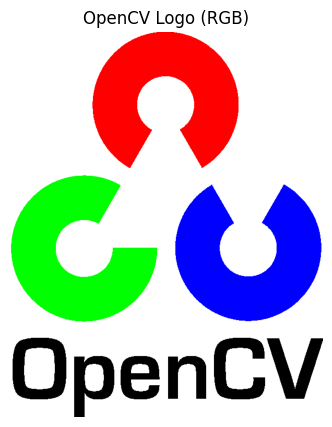

In [2]:
logo_bgr = load_bgr("opencv-logo.png")
logo_rgb = bgr_to_rgb(logo_bgr)

print(f"Shape (H, W, C): {logo_bgr.shape}")
print(f"Total pixels: {logo_bgr.size}")

show(logo_rgb, title="OpenCV Logo (RGB)")

## 3) Synthetic Images with NumPy
Create **black** and **white** images directly from arrays.


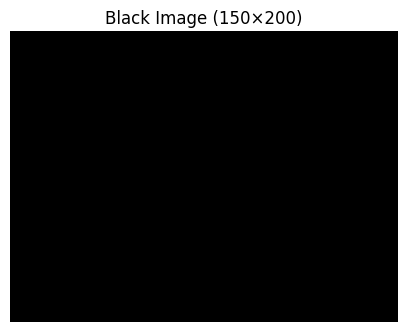

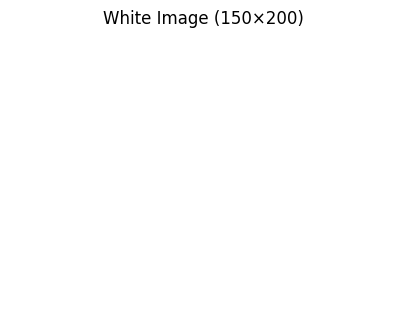

In [3]:
black = np.zeros((150, 200, 3), dtype=np.uint8)
white = np.ones((150, 200, 3), dtype=np.uint8) * 255

show(black, title="Black Image (150×200)")
show(white, title="White Image (150×200)")

## 4) Color Channels & Color Spaces
Visualize the **R, G, B** channels independently and convert the image to **HSV**.


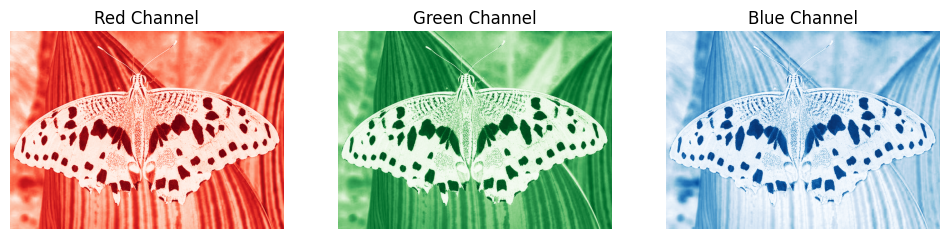

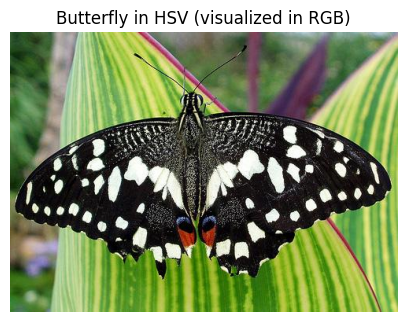

In [4]:
butterfly_bgr = load_bgr("butterfly.jpg")
butterfly_rgb = bgr_to_rgb(butterfly_bgr)

# Split channels (on RGB image for intuitive visualization)
R, G, B = cv2.split(butterfly_rgb)

plt.figure(figsize=(12, 4))
for i, (ch, name, cm) in enumerate([(R, "Red Channel", "Reds"),
                                    (G, "Green Channel", "Greens"),
                                    (B, "Blue Channel", "Blues")]):
    plt.subplot(1, 3, i+1)
    plt.imshow(ch, cmap=cm)
    plt.title(name)
    plt.axis("off")
plt.show()

# HSV conversion (OpenCV uses BGR as input)
butterfly_hsv = cv2.cvtColor(butterfly_bgr, cv2.COLOR_BGR2HSV)
# Convert back to RGB for display
butterfly_hsv_rgb = cv2.cvtColor(butterfly_hsv, cv2.COLOR_HSV2RGB)
show(butterfly_hsv_rgb, title="Butterfly in HSV (visualized in RGB)")

## 5) NumPy Arrays & Pixel Slicing
Here we load the OpenCV logo image and isolate the blue channel by setting the red and green channels to zero, while preserving the original alpha channel. This highlights only the blue component of the logo.

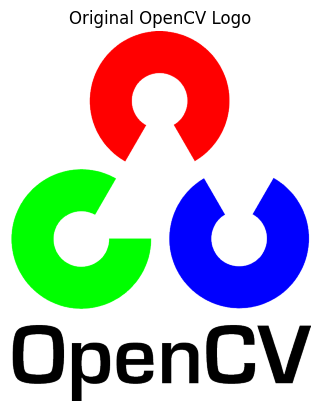

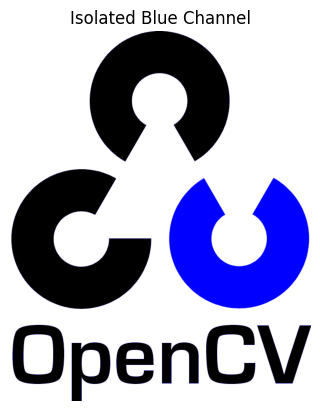

In [5]:
import cv2, numpy as np, matplotlib.pyplot as plt

DATA_DIR = "../Data"
img_path = os.path.join(DATA_DIR, "opencv-logo.png")

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # BGRA if PNG has alpha
if img is None:
    raise FileNotFoundError

if img.shape[2] == 4:   # BGRA
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA))
else:                   # BGR only
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.title("Original OpenCV Logo")
plt.axis("off")
plt.show()

if img.shape[2] == 4:  # BGRA
    b, g, r, a = cv2.split(img)
    zeros = np.zeros_like(b)
    # keep B and the original alpha; zero R & G
    blue_rgba = cv2.merge([b, zeros, zeros, a])  # BGRA
    plt.imshow(cv2.cvtColor(blue_rgba, cv2.COLOR_BGRA2RGBA))
    plt.title("Isolated Blue Channel")
    plt.axis("off")
    plt.show()
else:
    print("Image has no alpha — use Way 2 below.")

## 6) Resizing & Interpolation
Compare **half-size** scaling and stretching with **linear** vs **nearest** interpolation.


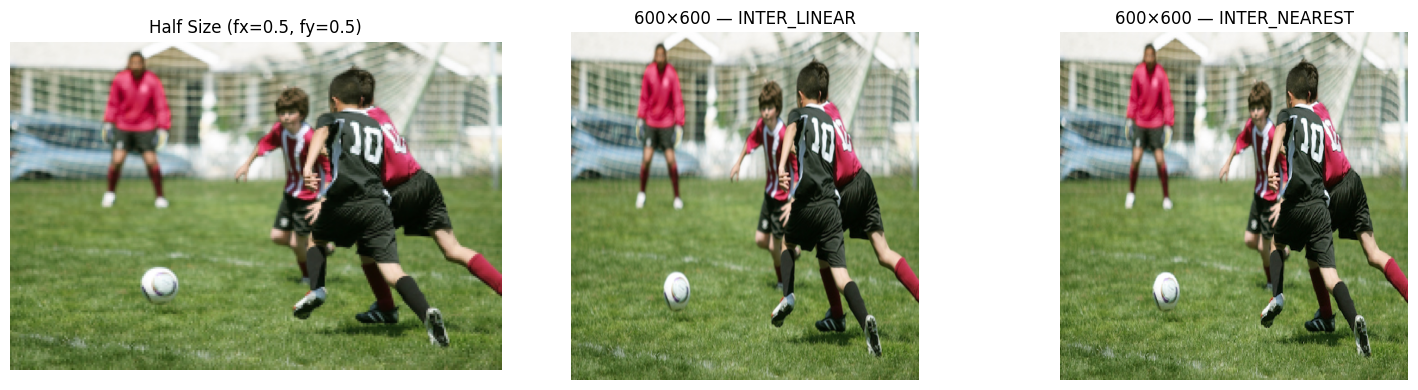

In [6]:
players_bgr = load_bgr("players.jpg")
players_rgb = bgr_to_rgb(players_bgr)

half = cv2.resize(players_rgb, (0, 0), fx=0.5, fy=0.5)
resized_linear = cv2.resize(players_rgb, (600, 600), interpolation=cv2.INTER_LINEAR)
resized_nearest = cv2.resize(players_rgb, (600, 600), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(15, 4))
for i, (im, title) in enumerate([(half, "Half Size (fx=0.5, fy=0.5)"),
                                 (resized_linear, "600×600 — INTER_LINEAR"),
                                 (resized_nearest, "600×600 — INTER_NEAREST")]):
    plt.subplot(1, 3, i+1)
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()

## 7) Region of Interest (ROI) & Rotation
Draw a rectangle around a region, crop it, and rotate the crop **without clipping**.


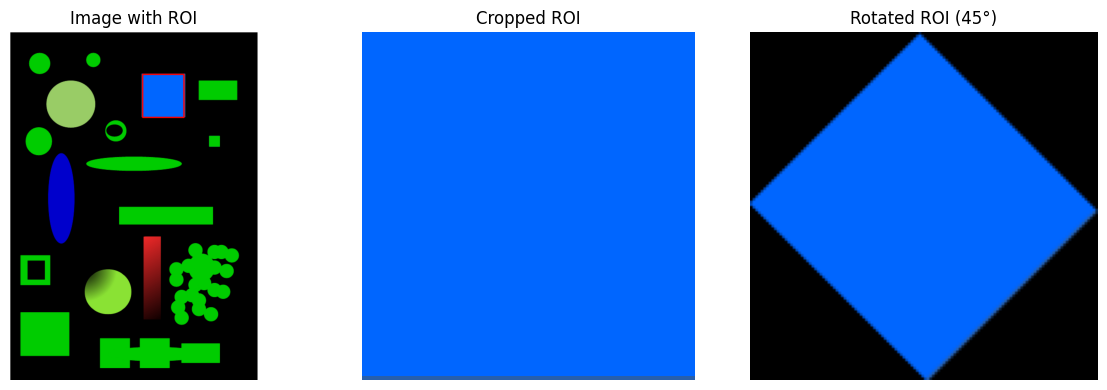

In [7]:
blob_bgr = load_bgr("detect_blob.png")
blob_rgb = bgr_to_rgb(blob_bgr)

# Manually-specified ROI for the solid blue square (tweak if needed for your image)
x, y, w, h = 289, 92, 90, 94
boxed = blob_rgb.copy()
cv2.rectangle(boxed, (x, y), (x+w, y+h), (255, 0, 0), 2)

roi = blob_rgb[y:y+h, x:x+w]

# Rotate ROI by 45° without clipping
(h_roi, w_roi) = roi.shape[:2]
center = (w_roi // 2, h_roi // 2)
M = cv2.getRotationMatrix2D(center, 45, 1.0)
cos, sin = abs(M[0, 0]), abs(M[0, 1])
new_w = int((h_roi * sin) + (w_roi * cos))
new_h = int((h_roi * cos) + (w_roi * sin))
M[0, 2] += (new_w / 2) - center[0]
M[1, 2] += (new_h / 2) - center[1]
rotated = cv2.warpAffine(roi, M, (new_w, new_h))

plt.figure(figsize=(12, 4))
for i, (im, title) in enumerate([(boxed, "Image with ROI"),
                                 (roi, "Cropped ROI"),
                                 (rotated, "Rotated ROI (45°)")]):
    plt.subplot(1, 3, i+1)
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()

## 8) Thresholding, Morphology & Canny Edges
Demonstrate classic preprocessing steps and how **edge thresholds** affect results.


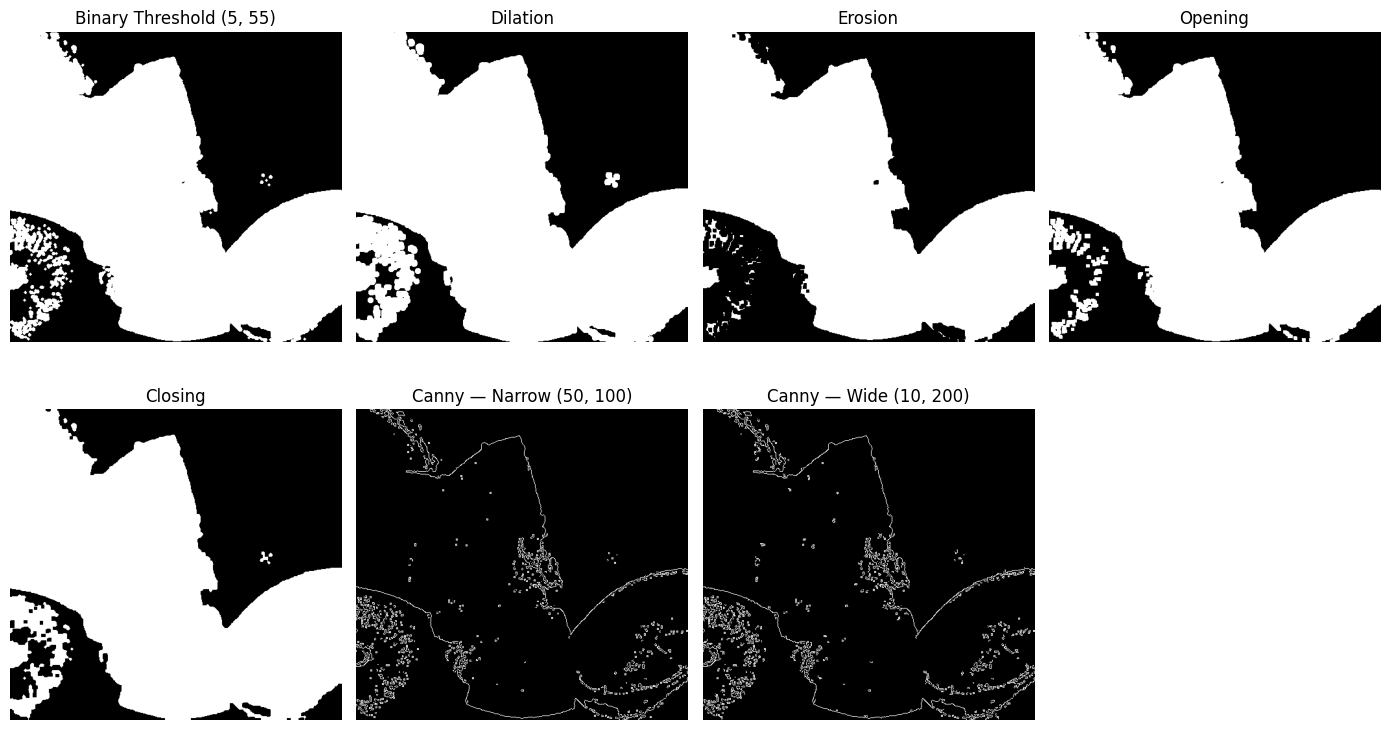

In [8]:
thresh_gray = cv2.imread(os.path.join("../Data", "thresh.jpg"), cv2.IMREAD_GRAYSCALE)
if thresh_gray is None:
    raise FileNotFoundError("Could not read ../Data/thresh.jpg.")

blurred = cv2.GaussianBlur(thresh_gray, (5, 5), 0) 

# Binary threshold (values can be tuned per dataset)
_, binary = cv2.threshold(blurred, 5, 55, cv2.THRESH_BINARY)

kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(binary, kernel, iterations=1)
eroded = cv2.erode(binary, kernel, iterations=1)
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

edges_narrow = cv2.Canny(thresh_gray, 50, 100)
edges_wide   = cv2.Canny(thresh_gray, 10, 200)

plt.figure(figsize=(14, 8))
titles_imgs = [
    (binary, "Binary Threshold (5, 55)"),
    (dilated, "Dilation"),
    (eroded, "Erosion"),
    (opened, "Opening"),
    (closed, "Closing"),
    (edges_narrow, "Canny — Narrow (50, 100)"),
    (edges_wide, "Canny — Wide (10, 200)")
]
for i, (im, ttl) in enumerate(titles_imgs, start=1):
    plt.subplot(2, 4, i)
    plt.imshow(im, cmap="gray")
    plt.title(ttl)
    plt.axis("off")
plt.tight_layout()
plt.show()

## 9) Drawing Shapes & Flipping
Flip an image vertically, draw a **red rectangle**, and draw/fill a **blue triangle**.
Also, load a chess/football image and fix its color order for display.


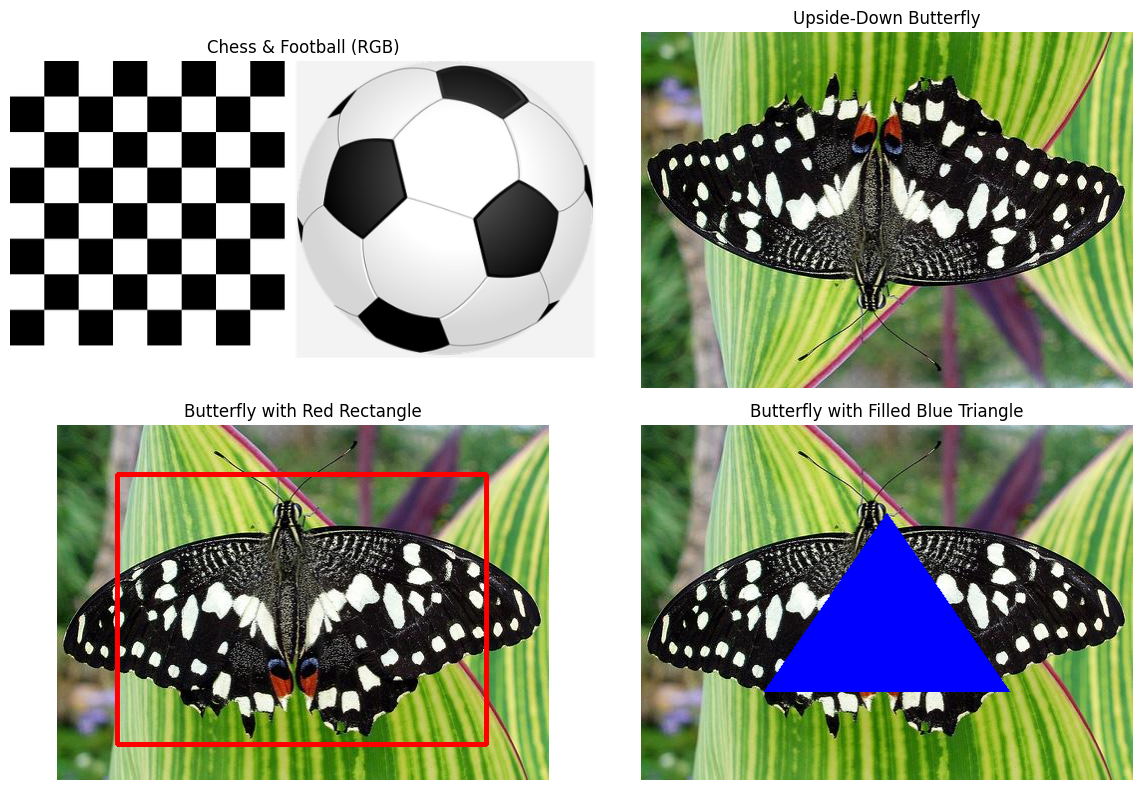

In [9]:
butter_bgr = load_bgr("butterfly.jpg")
butter_rgb = bgr_to_rgb(butter_bgr)

# Flip vertically (upside-down)
flipped = cv2.flip(butter_rgb, 0)

# Red rectangle (coordinates calibrated for this image; adjust if needed)
rect_img = butter_rgb.copy()
cv2.rectangle(rect_img, (60, 50), (430, 320), (255, 0, 0), 3)  # red in RGB

# Blue triangle in the middle
triangle_img = butter_rgb.copy()
h, w = triangle_img.shape[:2]
pts = np.array([[w//2, h//4], [w//4, 3*h//4], [3*w//4, 3*h//4]], dtype=np.int32)
cv2.fillPoly(triangle_img, [pts.reshape(-1, 1, 2)], color=(0, 0, 255))  # blue fill

# Chess & football image
chess_bgr = load_bgr("chess_football.png")
chess_rgb = bgr_to_rgb(chess_bgr)

plt.figure(figsize=(12, 8))
imgs = [(chess_rgb, "Chess & Football (RGB)"),
        (flipped, "Upside-Down Butterfly"),
        (rect_img, "Butterfly with Red Rectangle"),
        (triangle_img, "Butterfly with Filled Blue Triangle")]
for i, (im, ttl) in enumerate(imgs, start=1):
    plt.subplot(2, 2, i)
    plt.imshow(im)
    plt.title(ttl)
    plt.axis("off")
plt.tight_layout()
plt.show()

## 10) Interactive Drawing (Local Run)
Right-click anywhere on the image to draw an **empty red circle**.  
This uses OpenCV's **HighGUI** API and works best when running the notebook **locally**.

> If you're viewing on GitHub or a hosted notebook where GUI windows aren't supported, skip this cell.


In [ ]:
RUN_GUI = True  # set to True when running locally with GUI support

if RUN_GUI:
    cam_path = os.path.join("../Data", "cameraman.jpg")
    cam_gray = cv2.imread(cam_path, cv2.IMREAD_GRAYSCALE)
    if cam_gray is None:
        raise FileNotFoundError(f"Could not read {cam_path}. Make sure it exists in Data/")

    canvas = cv2.cvtColor(cam_gray, cv2.COLOR_GRAY2BGR).copy()

    def on_mouse(event, x, y, flags, param):
        if event == cv2.EVENT_RBUTTONDOWN:
            # Draw an empty red circle
            cv2.circle(canvas, (x, y), 20, (0, 0, 255), 2)

    cv2.namedWindow("Draw Circles (Right-Click)")
    cv2.setMouseCallback("Draw Circles (Right-Click)", on_mouse)

    while True:
        cv2.imshow("Draw Circles (Right-Click)", canvas)
        # ESC to exit
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cv2.destroyAllWindows()
else:
    print("GUI disabled. Set RUN_GUI=True to try this locally.")

## 11) Convolution, Sobel Edges & Color Histograms
Apply a small **low-pass** blur, **Sobel X** edges, and plot the **RGB histograms**.


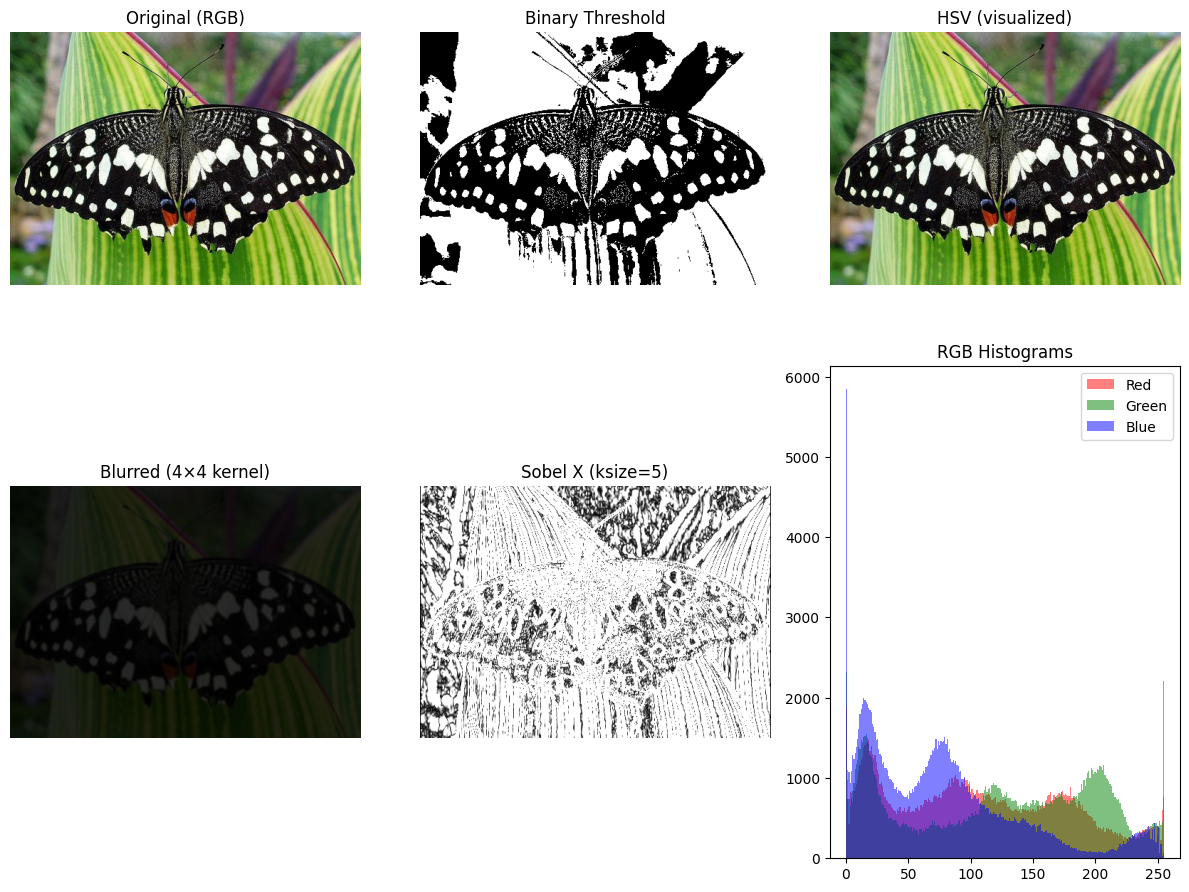

In [11]:
img_bgr = load_bgr("butterfly.jpg")
img_rgb = bgr_to_rgb(img_bgr)
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Binary threshold (for demonstration)
_, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

# HSV (visualized back in RGB)
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
hsv_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# 4×4 low-pass (sum = 16 * 0.01 = 0.16; mild blur for demo)
kernel = np.ones((4, 4), np.float32) * 0.01
blurred = cv2.filter2D(img_rgb, -1, kernel)

# Sobel X on grayscale
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobelx_abs = cv2.convertScaleAbs(sobelx)

plt.figure(figsize=(12, 10))
plt.subplot(2, 3, 1); plt.imshow(img_rgb); plt.title("Original (RGB)"); plt.axis("off")
plt.subplot(2, 3, 2); plt.imshow(binary, cmap="gray"); plt.title("Binary Threshold"); plt.axis("off")
plt.subplot(2, 3, 3); plt.imshow(hsv_rgb); plt.title("HSV (visualized)"); plt.axis("off")
plt.subplot(2, 3, 4); plt.imshow(blurred); plt.title("Blurred (4×4 kernel)"); plt.axis("off")
plt.subplot(2, 3, 5); plt.imshow(sobelx_abs, cmap="gray"); plt.title("Sobel X (ksize=5)"); plt.axis("off")
plt.subplot(2, 3, 6)
r, g, b = img_rgb[..., 0], img_rgb[..., 1], img_rgb[..., 2]
plt.hist(r.ravel(), bins=256, color='red', alpha=0.5, label='Red')
plt.hist(g.ravel(), bins=256, color='green', alpha=0.5, label='Green')
plt.hist(b.ravel(), bins=256, color='blue', alpha=0.5, label='Blue')
plt.title("RGB Histograms"); plt.legend()
plt.tight_layout(); plt.show()

---

## 12) Conclusion
This project compiles core computer-vision building blocks with clean, readable code and practical demonstrations.
It serves as a **foundation** for more advanced tasks such as segmentation, detection, and tracking.

**Next steps to extend this repo:**
- Add ORB/SIFT/SURF feature detection demos
- Template matching & object localization
- Perspective transform (homography) mini-demo
- Small pipeline that combines preprocessing + detection

**Author:** Rohit Ravula  
Email: rohitsaikiran.r@gmail.com  
GitHub: [@Rohit Sai Kiran](https://github.com/RohitSaiKiran)